If we are running an ABtesting, how many sample should we collect? Here comes **Exploit or Explore** problem.
Traditionally, we cannot stop the experiment once the p-value lower than significance threshold. The reason is that even if the data are evenly distribute, we still have 5% of chance to observe difference in between. In general, we can choose sample size
$$ N = 16\frac{\sigma^2}{\delta^2} $$
In Bayesian statistic, typically requires less samples to meet the threshold, and one can stop an experiment at any time and calculate exact probalilities given data.

#### Epsilon-Greedy
Randomly shows advertisements to users and collecting response. Shows the best ad given evidence so far.
#### Problem
After N impressions
Reward = N(1-eps/2) rather than N even if we have strong confidence that A is better than B

In [7]:
# Epsilon-Greedy psudo code
"""
import random
eps = 0.1
while True:
    r = random.random()
    if r < eps:
        #explore
        #show random ad
        #update ctr
        pass
    else:
        #exploit
        #show best advertisement
        break
"""

#### Upper Confidence Bound (Chernoff-Hoeffding Bound)
Describe the probabity of observed mean derviate from sample mean
$$ P(|\hat\mu - \mu| \le \epsilon) \gt 1 - 2e^{-2\epsilon^2N}$$
We choose the epsilon for each target
$$ \epsilon_j = \sqrt{\frac{2lnN}{N_j}}$$
In sum,
1. if ctr estimate high, we exploit more.
2. if N is high, but Nj is low, we are not so confident about CTRj, so explore this more
3. as N -> inf , ln(N)/N approach to 0, so we use only the tre CTR in the limit
4. loss is proportional to ln(N), perform better than epsilon greedy ~ N

In [ ]:
#UCB psudo code
"""
N = 0
Nj = 0 for all bandits j
while True:
    j* = argmax(u_j + epsilon_j)
    play arm j*
    update u*
    N++; Nj*++
"""

#### Bayesian Approach
Recall the bayes rule
$$ P(\theta|x) = \frac{P(X|\theta)P(\theta)}{marginal \space likelihood}$$
The beauty of bayes inference is that the model parameters are considered as a random variable with certain probability distribution. Unlike frequencist, we draw confidence level to obtain p-value and we have (must) test certain number of trail reach the statistical significent in the frequencist way. 

In bayes' world, model parameter is a random variable with some distributions, and we update the distribution's parameter base on known data. 

In this example, I will show how to applied it to ABTesting. 
#### Problem
Suppose we enter a casino and play the slot machine. Each of machine has set a constant probability to win. We want to decide which machine has the best chance to win.
#### A little bit of conjugate pior and bin-beta distribution
Note that the RHS of bayes rule, $P(X|\theta)$ is the likelihood given parameter $\theta$ and $P(\theta)$ is the pior. In our example, our chance to win is bernouli distribution, namely $Pro(x=1) = p$  and $Pro(x=0) = 1-p$. How do we select the prior distribution? From Wiki, the definition of conjugate prior is
> If the posterior distributions $p(θ|x)$ are in the same family as the prior probability distribution $p(θ)$, the prior and posterior are then called conjugate distributions, and the prior is called a conjugate prior for the likelihood function.

For example a normal distribution function mulitply by another normal distribution function is also normal distributed. 
$$N(\mu_1,\sigma_1) \times N(\mu_2,\sigma_2) = N(\frac{\mu_1/\sigma_2+\mu_2/\sigma_1}{\sigma_1+\sigma_2},\frac{\sigma^2_1+\sigma^2_2}{\sigma_1^2\sigma_2^2}) $$
In our case, the conjugate prior of a Bernouli distribution is the Beta distribution.
$$Beta(\alpha,\beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}$$
Therefore, we have
$$P(p|X) = Beta(\alpha',\beta') \propto P(x=1)Beta(\alpha,\beta)   $$
Where $\alpha' = \alpha + \Sigma x_i(number \space of \space successful \space tests)$ and $\beta' = \beta + n - \Sigma x_i$
In sum, we want to determine the probability distribution of winning possibility p. First we assume a prior with $\alpha=1$ and $\beta=1$. Then we pull the arm and see the result, if test success, update the $\alpha'=\alpha+1, \beta' = \beta$ and vice versa. We repeat this process and every time new posterior will suggest us the winning possibility is $p=\alpha'/(\alpha'+\beta'). That's it. The result is nothing different from pulling a machine 100 times and calculate the probability by counting number of success and failure. But now we not only have the mean value but also a probability distribution. 

Now, the following algorithm is an ABTesting application base on Bayesian theorem.
1. setup the prior for each machine. $\alpha^{[0]}_0=\alpha^{[1]}_1=\alpha^{[1]}_2=\beta^{[0]}_0=\beta^{[1]}_1=\beta^{[1]}_2=1$
2. draw a sample from each prior
3. pull the arm of the machine gives you the largest sample
4. update the posterior according to your test result
5. repeat 1-4

In [22]:
# From the course: Bayesin Machine Learning in Python: A/B Testing
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]
class Bandit(object):
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1

    def pull(self):
        return np.random.random() < self.p

    def sample(self):
        return np.random.beta(self.a, self.b)

    def update(self, x):
        self.a += x
        self.b += 1 - x


def plot(bandits, trial):
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label="real p: %.4f" % b.p)
    plt.title("Bandit distributions after %s trials" % trial)
    plt.legend()
    plt.show()


def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
    sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
    n_pulling = [0,0,0]
    for i in range(NUM_TRIALS):
        # take a sample from each bandit
        bestb = None
        maxsample = -1
        allsamples = [] # let's collect these just to print for debugging
        for n,b in enumerate(bandits):
            sample = b.sample()
            allsamples.append("%.4f" % sample)
            if sample > maxsample:
                maxsample = sample
                bestb = b
                index = n
        if i in sample_points:
            print("current samples: %s" % allsamples)
            print("number of pulling: {:d} {:d} {:d}".format(n_pulling[0],n_pulling[1],n_pulling[2]))
            plot(bandits, i)
        # pull the arm for the bandit with the largest sample
        x = bestb.pull()
        n_pulling[index]+=1
        # update the distribution for the bandit whose arm we just pulled
        bestb.update(x)

current samples: ['0.5033', '0.6488', '0.6965']
number of pulling: 1 1 3


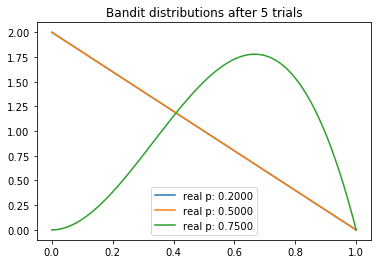

current samples: ['0.8886', '0.6938', '0.4719']
number of pulling: 1 1 8


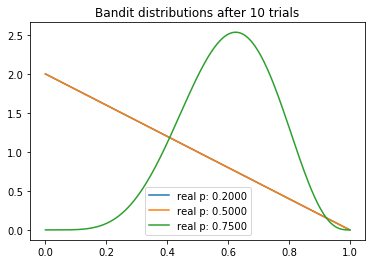

current samples: ['0.1069', '0.0015', '0.6547']
number of pulling: 2 1 17


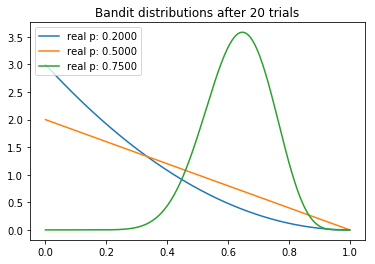

current samples: ['0.3795', '0.4870', '0.5500']
number of pulling: 4 4 42


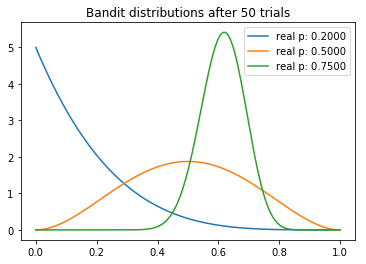

current samples: ['0.4008', '0.6673', '0.6413']
number of pulling: 4 24 72


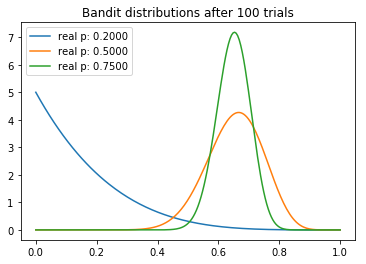

current samples: ['0.1701', '0.4922', '0.6593']
number of pulling: 4 40 156


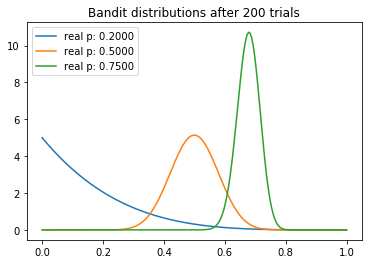

current samples: ['0.3243', '0.5175', '0.7427']
number of pulling: 4 40 456


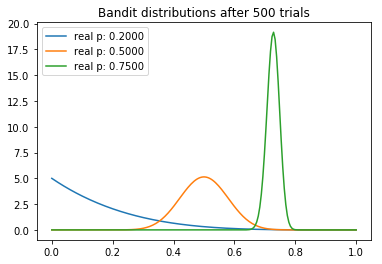

current samples: ['0.0855', '0.4518', '0.7321']
number of pulling: 5 41 954


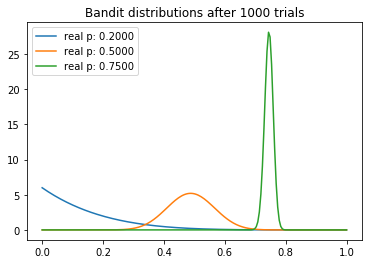

current samples: ['0.1816', '0.5447', '0.7541']
number of pulling: 5 41 1454


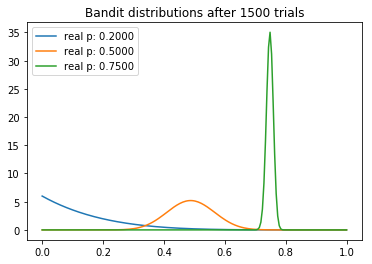

current samples: ['0.0476', '0.4613', '0.7408']
number of pulling: 6 41 1952


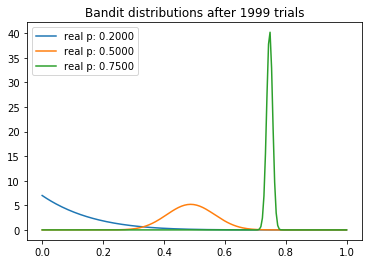

In [23]:
experiment()

Credits: 
1. Bayessian AB testing at Udemy
2. https://www.evanmiller.org/bayesian-ab-testing.html
3. https://www.chrisstucchio.com/blog/2014/bayesian_ab_decision_rule.html     